<a href="https://colab.research.google.com/github/nikopj/SummerML/blob/master/Day3/Day3-Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 3: Generalization Error, Regularization

##Why do we need Regularization?

When we use a dataset that has too many parameters, we might end up with a generalization error. Only a few of these parameters are useful in the prediction process. We need to find out which of them are important to us. To do this, we use regularization to constrain the parameters with some prior knowledge about the parameters. Let's call this feature selection. 

There are two well-known regularizers:
1. L1 Norm (A regression model using L1 is called **LASSO**)
2. L2 Norm (A regression model using L2 is called **Ridge**)

**See slides for theory.**
 
Let's understand this further using an example. 

##Example:  Prostate Cancer Analysis with LASSO and Other Feature Selection Methods**

In this example, we will show the how we use LASSO regularization and other feature selection methdos for model (feature) selection.  

We will learn to:
* Fit a LASSO model using the 'sklearn' package
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level
* Try out other feature selection methods in 'sklearn'

We use a classic prostate cancer dataset from this [paper](http://www.sciencedirect.com/science/article/pii/S002253471741175X):

**An overview of the dataset:**

* In the study, the level of PSA [(prostate specific antigen)](https://en.wikipedia.org/wiki/Prostate-specific_antigen) was measured in 102 men before they had a prostatectomy. 
* Elevated values of the PSA are believed to be associated with the presence of prostate cancer and other disorders. 
* To study this hypothesis, various features of the prostate were measured after the prostatectomy.  
* Data analysis is then used to understand the relation between the PSA level and prostate features.  



Let's first **load** the regular packages.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Data

Let's start by getting the data from Tibshirani's [website](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data).

In [0]:
# Get the data
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)   # skip the column of indices

In this data set, the target variable (the variable that we are trying to predict) is 'lpsa', which stands for the log of the PSA. 

The goal is to try  to predict the 'lpsa' from various prostate features.

In [0]:
# Print the names of the target and predictor
names = df.columns.tolist()
names_x = names[0:7]
name_y = names[8]
print("Target variable: %s" % name_y)
print("Predictors:     "+str(names_x))

# Convert the dataframe values to data matrices
X0 = np.array(df[names_x])
y0 = np.array(df[name_y])

# Print the number of samples and features
nsamp = X0.shape[0]
nfeatures = X0.shape[1]
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))

Target variable: lpsa
Predictors:     ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason']

num samples = 97,  num features = 7


When performing any regularized estimate, it is critical to **standardize the values**.  
For this purpose, we use python's sklearn's built-in *`scale`* command.

In [0]:
import sklearn.preprocessing

X = sklearn.preprocessing.scale(X0)
y = sklearn.preprocessing.scale(y0)


## Fit a Linear Model with No Regularization

Let's first try to fit a multiple linear model with no regularization.  We begin by importing the required packages - *`linear_model`* and *`train_test_split`*

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

We next split the data into training and test -- will use roughly half the samples for each.

In [0]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.5,shuffle=True)
#test_size=0.5, uses half of the data as test data
#shuffle=True, will shuffle the data before splitting
#X_tr is the training feature matrix
#X_ts is the testing feature matrix
#y_tr is the training target matrix
#y_ts is the testing target matrix

ntr = X_tr.shape[0]
nts = X_ts.shape[0]
#.shape[0], will give us the number of rows of that array
#.shape[1], will give us the number of columns of that array

print("num samples train = %d, test = %d" % (ntr, nts))

num samples train = 48, test = 49


Fit the model on the training data.

In [0]:
regr = linear_model.LinearRegression()

regr.fit(X_tr,y_tr) #will fit the model on the X_tr,y_tr, our training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now, we can measure the normalized Residual Sum of Squares (RSS) on the training data, to check the accuracy of the prediction.  

In [0]:
# Predict the target training variables (y_tr_pred), from feature training 
# variables (X_tr)
y_tr_pred = regr.predict(X_tr)

# Measure normalized RSS
rss_tr = np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
rsq_tr = 1-rss_tr
print("RSS training = %f" % rss_tr)
print("R^2 training = %f" % rsq_tr)

#or we can use an in-built sklearn function
from sklearn.metrics import r2_score

rsq_tr_sk = r2_score(y_tr, y_tr_pred)
print("R^2 training using the in-built function= %f" % rsq_tr_sk)

RSS training = 0.292958
R^2 training = 0.707042
R^2 training using the in-built function= 0.707042


Ths `R^2` value is around `0.70`.  However, we need to evaluate the model on the test data.  

In [0]:
y_ts_pred = regr.predict(X_ts)

rss_ts = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
rsq_ts = 1-rss_ts
print("Normalized test RSS = %f" % rss_ts)
print("Normalized test R^2 = %f" % rsq_ts)

Normalized test RSS = 0.447831
Normalized test R^2 = 0.552169


We can also plot the actual vs. predicted values.  We see a clear fit.

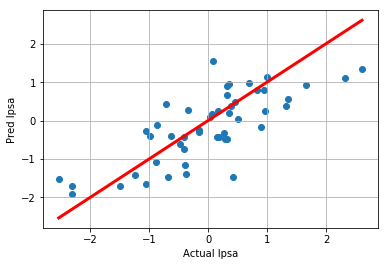

In [0]:
plt.scatter(y_ts,y_ts_pred)
plt.xlabel('Actual lpsa')
plt.ylabel('Pred lpsa')
ymin = np.min(y_ts)
ymax = np.max(y_ts)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()

We can also plot the coefficients in the regression model.  Remember that all the parameters are normalized so that the coefficients can be compared.  We see that `lcavol` has the highest weight, but there are non-zero weights on all the predictors.  This makes it hard to see if other factors are significant or not. 

    lcavol    0.6618
   lweight    0.0843
       age   -0.1344
      lbph    0.2016
       svi    0.2222
       lcp   -0.0700
   gleason    0.1669


<StemContainer object of 3 artists>

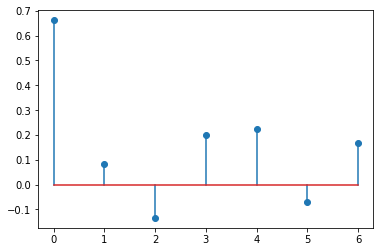

In [0]:
w = regr.coef_
for name, wi in zip(names_x, w):
    print('%10s %9.4f' % (name, wi))
    
plt.stem(w)    

## LASSO:  Linear Model with L1 Regularization

The above seen failure of the linear model motivates us to use regularization to try to select only the "useful" features. 

Let's discuss how we use the Lasso technique.  

The `sklearn` package has several excellent routines for this. We first import the *`model_selection`* sub-package for the k-fold cross validation.

In [0]:
import  sklearn.model_selection 

When considering the LASSO, we consider a set of models with different levels of regularization `alpha`.  Higher values of `alpha` imply greater regularization.  We use k-fold cross validation to determine the appropriate `alpha`.  That is, for each `alpha` value, we evaluate the test error on different training / tests spilt.   For larger data sets, this exhaustive search is time-consuming.  But, it should finish very fast for this small set. 

In [0]:
# Create a k-fold cross validation object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Create a LASSO model object
        model = linear_model.Lasso(alpha=a)
        
        # Fit the model on the training data
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

We now plot the test MSE (Mean Square Error) as a function of the regularization parameter.

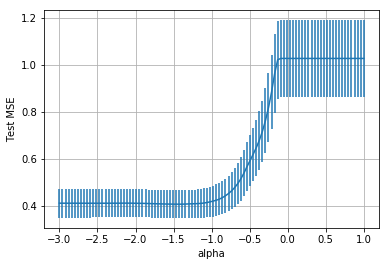

In [0]:
# Compute the mean and standard deviation over the different folds.
mse_mean = np.mean(mse,axis=1)
mse_se = np.std(mse,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE with 1 SE error bars
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

We find the optimal `alpha`, by the following steps:
* Find the `alpha` with the minimum test MSE
* Set `mse_tgt = ` minimum MSE + 1 std dev MSE
* Find the least complex model (highest `alpha`) such that `MSE < mse_tgt`

Optimal alpha = 0.166810


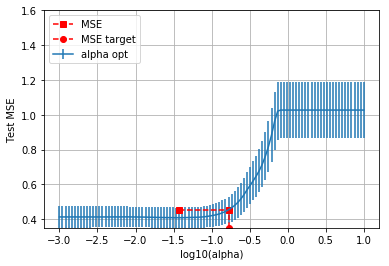

In [0]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_se[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 SE errorbars 
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)

# Plot the MSE target
amin_log = np.log10(alpha_min)
aopt_log = np.log10(alpha_opt)
plt.plot([amin_log,aopt_log], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.plot([aopt_log,aopt_log], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['MSE', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.ylim([0.35,1.6])
plt.grid()
plt.show()


Finally, we recompute the coefficients using all the training data at the correct alpha.  We see that the model selects three non-zero cofficients:  `lcavol`, `lweight` and `svi` (description of the features can be found in  https://rafalab.github.io/pages/649/prostate.html).  These features are presumably the most relevant in determining the PSA level.  Interestingly, the first feature -- `lcavol` -- is the log of the cancer volume suggesting that the cancer volume does indeed influence the PSA level.

In [0]:
model.alpha = alpha_opt
model.fit(X,y)

# Print the coefficients
for i, c in enumerate(model.coef_):
    print("%8s %f" % (names_x[i], c))

  lcavol 0.464526
 lweight 0.115832
     age 0.000000
    lbph 0.000000
     svi 0.131102
     lcp 0.000000
 gleason 0.000000


Using the three chosen features, we now use linear regression method directly with cross validation to evaluate the test error and  to determine the mean regression coefficients.

In [0]:
# Find coefficients greater than a small threshold
Isel = np.where(np.abs(model.coef_) > 1e-3)[0]


# Select those features
X1=X[:,Isel]
nfea1 = len(Isel)

# Run 10-fold validation with reduced feature matrix
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# MSE for each alpha and fold value
RSS_ts = np.zeros((nfold,1))
coef=np.zeros((nfold,nfea1))
for ifold, ind in enumerate(kf.split(X1)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X1[Itr,:]
    y_tr = y[Itr]
    X_ts = X1[Its,:]
    y_ts = y[Its]
    
    regr.fit(X_tr,y_tr)
    y_ts_pred = regr.predict(X_ts)
    RSS_ts[ifold] = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
    coef[ifold]=regr.coef_
            
mse_mean = np.mean(RSS_ts,axis=0)
mse_se = np.std(RSS_ts,axis=0) / np.sqrt(nfold-1)
coef_mean=np.mean(coef,axis=0)
print("mse_mean=%f mse SE=%f" % (mse_mean, mse_se))
print(coef_mean)


mse_mean=0.539487 mse SE=0.106768
[0.53669232 0.2453695  0.23853759]


## LASSO path

To further illustrate the effect of regularization, we conclude by drawing the *LASSO path*.  This is simply a plot of the coefficients as a function of the regularization `alpha`.  We do not need to do this for the analysis, but the path demonstrates the effect of regularization well. 


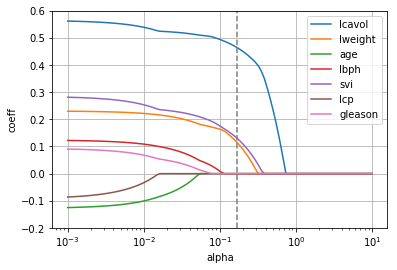

In [0]:
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X, y, alphas=alphas)

# Plot the paths of the coefficients
plt.semilogx(alphas1,coeffs.T)
plt.grid()
plt.legend(names_x, loc='upper right')


# Plot a line on the optimal alpha
plt.semilogx([alpha_opt,alpha_opt], [-0.2,0.6], '--')
plt.ylim([-0.2,0.6])
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.show()





---



# Exercise on LASSO Regression

In this exercise, we will see how to use LASSO for pitch detection and denoising in audio.

We load the following packages.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.io.wavfile import read

## Generate the Data

The data is generated from extracting samples of the `viola.wav` file.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving viola_sample.p to viola_sample.p


In [0]:
from scipy.io import wavfile

# Read the file
sr, yfull = wavfile.read('./apple/Downloads/viola_sample.p')

# Convert to floating point values so that compuations below do not overflow
yfull = yfull.astype(float)

FileNotFoundError: ignored

In [0]:
I = np.arange(100000,100000+800)
y0 = yfull[I]
nt = len(y0)
t = np.arange(nt)/sr
plt.plot(t,y0)

We then add a small amount of noise.

In [0]:
snrfs = 20
ystd = np.std(y)
wstd = 10**(-0.05*snrfs)*ystd
w = np.random.normal(0,wstd,nt)
y = y0 + w

plt.plot(t,y)

In [0]:
fn_dst = 'viola_sample.p'
with open(fn_dst,'wb') as fp:
    pickle.dump([t,y], fp)

## Load the Data

The data is taken from a sample of about 20 ms of audio from a viola.  I have already pre-processed the data.  You can load it with the following command.  The value `t` is the time (in seconds) and `y` is the sample of audio (this is a mono recording).  Noise has been artificially added to the sample.

In [0]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/viola_sample.p'
fn_dst = 'viola_sample.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

with open(fn_dst,'rb') as fp:
    t,y = pickle.load(fp)

Plot the data `y` vs. `t`.  

In [0]:
# TODO
plt.plot(t,y)

## Creating Features for a Sinusoidal Model

We will try to fit a model of the form:

    y[i] = \sum_j a[j]*sin(2*pi*freq[j]*t[i]) + b[j]*cos(2*pi*freq[j]*t[i])

That is, `y[i]` is a sum of sinusoids.  This is a common model for audio signals since an instrument, such as a viola, produces discrete tones.  

This model is non-linear in the frequency parameters.  So, instead of trying to find the frequencies, we will fix a large number of frequencies and then require that the coefficients `a[j]` and `b[j]` are mostly sparse.  

We will use the following vector of frequencies.  This vector includes frequencies on the muscial scale as well as frequencies between the musical notes.

In [0]:
freq = 55*2**(np.arange(5*96)/96)

To fit the sinusoidal model, we will write a function to map the values `t` to 
the `sin` and `cos` features.  Finish the function `transform` that creates matrices:

    Xcos[i,j] = np.cos(2*np.pi*cos(2*np.pi*t[i]*freq[j])
    Xsin[i,j] = np.cos(2*np.pi*sin(2*np.pi*t[i]*freq[j])
    X = np.hstack((Xcos,Xsin))
    
So, if `freq` is length `d`, there will `2*d` features.  You can try to create the matrices using python broadcasting if you want to avoid a for loop.   

In [0]:
def transform(t,freq):
    # TODO
    # Xcos = ...
    # Xsin = ...
    Xcos = np.cos(2*np.pi*t[:,None]*freq[None,:])
    Xsin = np.sin(2*np.pi*t[:,None]*freq[None,:])
    
    X = np.hstack((Xcos,Xsin))    
    return X

**Split** the data `t` and `y` into training and test.  Use approximately 50% for each set.

In [0]:
from sklearn.model_selection import train_test_split

# TODO
ttr, tts, ytr, yts = train_test_split(t,y,test_size=0.5)

Transform the `ttr`, `tts` into `Xtr` and `Xts`.

In [0]:
# TODO
Xtr = transform(ttr,freq)
Xts = transform(tts,freq)

## Use LASSO to Find the Frequencies

We can now use LASSO regression to find the model
* Use LASSO regression with `alpha=500` to fit the model.  
* Find the R^2-score on the test data.
* Plot the predicted value of `y` for `t in [0,0.02]`.

In [0]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# TODO
# regr = Lasso(...)
regr = Lasso(alpha=500)
regr.fit(Xtr,ytr)
yhat = regr.predict(Xts)

rsq = r2_score(yts, yhat)
print(rsq)

In [0]:
tp = np.linspace(0,0.02,1000)
Xp = transform(tp,freq)
yp = regr.predict(Xp)

plt.plot(tp,yp)
plt.plot(tts,yts,'o',markersize=4)

Recall that you can find the coefficient in the model via `w = regr.coef_`.  If `freq` has `d` terms, then `w` will have `2*d` terms.
* Split the coefficients `w` into `a` and `b`, the terms for the `cos` and `sin` features.
* Plot `a` and `b` using `plt.stem`.
* Which frequencies is dominant in this track?

In [0]:
# TODO
w = regr.coef_
d = len(freq)
wcos = w[:d]
wsin = w[d:]
wabs = np.sqrt(wcos**2 + wsin**2)
plt.stem(freq, wabs)

im = np.argmax(wabs)
freqm = freq[im]

print('Dominant freq = %f' % freqm)

## Selecting the Optimal Alpha

* Find the optimal `alpha` using cross-validation

In [0]:
#TODO

from sklearn.model_selection import KFold

alphas = np.logspace(0,4,20)
nalpha = len(alphas)
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

X = transform(t,freq)

# R^2 for each alpha and fold value
rsq = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Create a LASSO model object
        model = Lasso(alpha=a)
        
        # Fit the model on the training data
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        rsq[ia,ifold] = r2_score(y_ts, y_ts_pred)
        
        print('alpha=%f %d rsq=%7.4f' % (a,ia,rsq[ia,ifold]))


In [0]:
rsq_mean = np.mean(rsq,axis=1)
rsq_se = np.std(rsq,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(alphas),rsq_mean,yerr=rsq_se)
plt.ylim([0.9,1])
plt.grid()

# Exercise:  Source Localization for EEG

EEG or [Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) is a powerful tool for neuroscientists in understanding brain activity.  In EEG, a patient wears a headset with electrodes that measures voltages at a number of points on the scalp.  These voltages arise from ionic currents within the brain.  A common *inverse problem* is to estimate the which parts of the brain caused the measured response.  Source localization is useful in understanding which parts of the brain are involved in certain tasks.  A key challenge in this inverse problem is that the number of unknowns (possible locations in the brain) is much larger than the number of measurements.  In this lab, we will use LASSO regression on a real EEG dataset to overcome this problem and determine the brain region that is active under an auditory stimulus.

In addition to the concepts in the [prostate LASSO demo](./demo_prostate.ipynb) you will learn to:
* Represent responses of multi-channel time-series data, such as EEG, using linear models
* Perform LASSO and Ridge regression
* Select the regularization level via cross-validation
* Visually compare the sparsity between the solutions

We first download standard packages.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data. The following command will download a `pickle` file `eeg_dat.p` to your local machine.  If you do want to create the data yourself, the program to create the data is in this directory in the github repository.

In [0]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

Fetching file eeg_dat.p [53MB].  This may take a minute..
File eeg_dat.p downloaded


Now run the following command which will get the data from the `pickle` file.

In [0]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)

To understand the data, there are three key variables:

nt = number of time steps that we measure data
nchan = number of channels (i.e. electrodes) measured in each time step
ncur = number of currents in the brain that we want to estimate.
Each current comes from one brain region (called a voxel) in either the x, y or z direction. So,

nvoxels = ncur / 3
The components of the X and Y matrices are:

Y[i,k] = electric field measurement on channel i at time k
X[i,j] = sensitivity of channel i to current j.
Using X.shape and Y.shape compute and print nt, nchan, ncur and nvoxels.

In [0]:
# TODO
# nt = ...
# ncur = ...
# nchan = ...
# nvoxels
nchan, ncur = X.shape
nchan, nt = Y.shape
nvoxels = ncur // 3
print('Number times   = %d' % nt)
print('Number currents = %d' % ncur)
print('Number voxels = %d' % nvoxels)
print('Number channels = %d' % nchan)

Number times   = 85
Number currents = 22494
Number voxels = 7498
Number channels = 305


## Ridge Regression

Our goal is to estimate the currents in the brain from the measurements `Y`.  One simple linear model is:

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Howeever, there is a problem:
*  There are `nt x ncur` unknowns in `W`
*  There are only `nt x nchan` measurements in `Y`.

In this problem, we have:

    number of measurements  << number of unknowns
    
We need to use regularization in these circumstances.  We first try Ridge regression.

First split the data into training and test.  Use the `train_test_split` function with `test_size=0.33`.

In [0]:
# TODO
# Xtr,Xts,Ytr,Yts = train_test_split(...) 
Xtr,Xts,Ytr,Yts = train_test_split(X,Y,test_size=0.33)

Use the `Ridge` regression object in `sklearn` to fit the model on the training data.  Use a regularization, `alpha=1`.

In [0]:
regr = Ridge(alpha=1)
regr.fit(Xtr,Ytr)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

Predict the values `Y` on both the training and test data.  Use the `r2_score` method to measure the `R^2` value on both the training and test.  You will see that `R^2` value is large for the training data, it is very low for the test data.  This suggest that even with regularization, the model is over-fitting the data.

In [0]:
# TODO
# rsq_tr = ...
# rsq_ts = ...
Yhat = regr.predict(Xtr)
rsq_tr = r2_score(Ytr, Yhat)
print('R^2 training = %7.4f' % rsq_tr)


Yhat = regr.predict(Xts)
rsq_ts = r2_score(Yts, Yhat)
print('R^2 test     = %7.4f' % rsq_ts)

R^2 training =  0.5904
R^2 test     =  0.2107


Next, try to see if we can get a better `R^2` score using different values of `alpha`.  Use cross-validation to measure the test `R^2` for 20 `alpha` values logarithmically spaced from `10^{-2}` to `10^{2}` (use `np.logspace()`).  You can use regular cross-validation.  You do not need to do `K`-fold.

In [0]:
# TODO
alphas = np.logspace(-2,2,20)
rsq = []

for a in alphas:
    regr = Ridge(alpha=a)
    regr.fit(Xtr,Ytr)
    
    Yhat = regr.predict(Xts)
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    print('alpha=%12.4e rsq=%7.4f' % (a,rsqi))

alpha=  1.0000e-02 rsq=-0.1536
alpha=  1.6238e-02 rsq=-0.0616
alpha=  2.6367e-02 rsq= 0.0177
alpha=  4.2813e-02 rsq= 0.0882
alpha=  6.9519e-02 rsq= 0.1507
alpha=  1.1288e-01 rsq= 0.2022
alpha=  1.8330e-01 rsq= 0.2376
alpha=  2.9764e-01 rsq= 0.2528
alpha=  4.8329e-01 rsq= 0.2475
alpha=  7.8476e-01 rsq= 0.2258
alpha=  1.2743e+00 rsq= 0.1939
alpha=  2.0691e+00 rsq= 0.1578
alpha=  3.3598e+00 rsq= 0.1220
alpha=  5.4556e+00 rsq= 0.0894
alpha=  8.8587e+00 rsq= 0.0617
alpha=  1.4384e+01 rsq= 0.0397
alpha=  2.3357e+01 rsq= 0.0233
alpha=  3.7927e+01 rsq= 0.0117
alpha=  6.1585e+01 rsq= 0.0039
alpha=  1.0000e+02 rsq=-0.0013


Plot the test `R^2` vs. `alpha`.  And print the maximum test `R^2`.  You should see that the maximum test `R^2` is still not very high.

Optimal R^2 =  0.2528


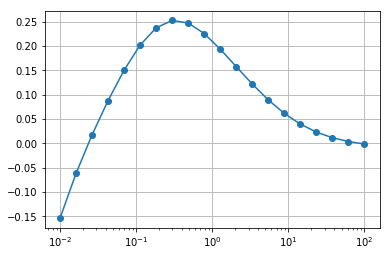

In [0]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal R^2 = %7.4f' % rsq_opt)

Now, let's take a look at the solution. 

* Find the optimal regularization `alpha` from the cross-validation
* Re-fit the model at the optimal `alpha`
* Get the current matrix `W` from the coefficients in the linear model.  These are stored in `regr.coef_`.  You may need a transpose
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )` which is root mean squared current.

You will see that the vector `Wrms` is not sparse.  This means that the solution that is found with Ridge regression finds currents in all locations.

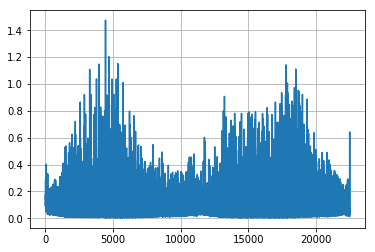

In [0]:
im = np.argmax(rsq)
aopt = alphas[im]

regr = Ridge(alpha=aopt)
regr.fit(Xtr,Ytr)

W = regr.coef_.T
Wrms = np.sqrt(np.sum(W**2, axis=1))

plt.plot(Wrms)
plt.grid()

## LASSO Regression

We can improve the estimate by imposing sparsity.  Biologically, we know that only a limited number of brain regions should be involved in the reponse to a particular stimuli.  As a result, we would expect that the current matrix `W[j,k]` to be zero for most values `j,k`.  We can impose this constraint using LASSO regularization.

Re-fit the training data using the `Lasso` model with `alpha=1e-3`.  Also set `max_iter=100` and `tol=0.01`.  The LASSO solver is much slower, so this make take a minute.

In [0]:
# TODO
regr = Lasso(alpha = 1e-3,max_iter=100,tol=0.01)
regr.fit(Xtr,Ytr)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

Now, test the model on the test data and measure the `R^2` value.  You should get a much better fit than with the Ridge regression solution.  

In [0]:
# TODO
Yhat = regr.predict(Xts)
rsq = r2_score(Yts, Yhat)
print(rsq)

0.190776902136011


We can now search for the optimal `alpha`.  Use cross-validation to find the `alpha` logarithically space between `alpha=10^{-3}` and `alpha=10^{-4}`.  Each fit takes some time, so use only 5 values of `alpha`. Also for each `alpha` store the current matrix.  This way, you will not have to re-fit the model.

In [0]:
alphas = np.logspace(-4,-3,5)
rsq = []
Ws = []

for a in alphas:
    
    # Fit the model
    regr = Lasso(alpha =a, max_iter=100, tol=0.01)
    regr.fit(Xtr,Ytr)
    
    # Predict 
    Yhat = regr.predict(Xts)
    
    # Score
    rsqi = r2_score(Yts, Yhat)
    rsq.append(rsqi)
    
    # Save the current matrix
    Ws.append(regr.coef_.T)
    
    
    # Print results
    print('alpha = %12.4e rsq=%7.4f' % (a, rsqi))

alpha =   1.0000e-04 rsq= 0.3279
alpha =   1.7783e-04 rsq= 0.3532
alpha =   3.1623e-04 rsq= 0.3345
alpha =   5.6234e-04 rsq= 0.2863
alpha =   1.0000e-03 rsq= 0.1908


Plot the `r^2` value vs. `alpha`.  Print the optimal `r^2`.  You should see it is much higher than with the best Ridge Regression case.

Optimal test R^2 =  0.3532


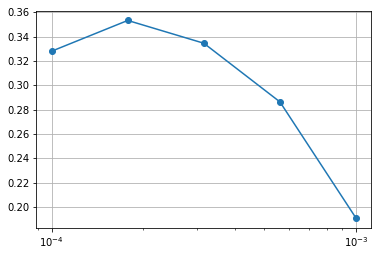

In [0]:
rsq = np.array(rsq)
plt.semilogx(alphas, rsq, 'o-')
plt.grid()

rsq_opt = np.max(rsq)
print('Optimal test R^2 = %7.4f' % rsq_opt)

Display the current matrix `W` for the optimal `alpha` as you did in the Ridge Regression case.  You will see that is much sparser.

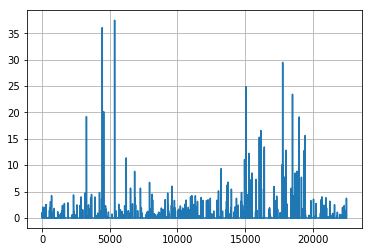

In [0]:
iopt = np.argmax(rsq)
Wopt = Ws[iopt]
Wrms = np.sqrt(np.sum(Wopt**2, axis=1))

plt.plot(Wrms)
plt.grid()